In [1]:
import sys
sys.path.append('../')

In [2]:
import keras
import numpy as np
import pandas as pd
import tensorflow as tf
from datetime import datetime
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Dropout

Using TensorFlow backend.


In [3]:
from utils.data_loaders import load_clc_db_records
from utils.features import construct_features_batch
from utils.data_handling import merge_asset_data, split_by_date
from utils.loss_functions import return_loss, sharpe_loss, return_loss_dummy, sharpe_loss_dummy

In [4]:
config = tf.ConfigProto(device_count = {'GPU': 1 , 'CPU': 8}) 
sess = tf.Session(config=config) 
keras.backend.set_session(sess)

In [5]:
RAD_DATA_PATH = '../data/clc/rad/'
FED_DATA_PATH = '../data/FEDFUNDS.csv'

In [6]:
clc = load_clc_db_records(RAD_DATA_PATH, FED_DATA_PATH)

In [7]:
assets_to_use = ['AN', 'BN', 'CC', 'CN', 'CT', 'DT', 'DX', 'EC', 'FB', 'FF', 'FN',
       'FX', 'GI', 'GS', 'JN', 'JO', 'KC', 'KW', 'LB', 'LX', 'MD', 'MW',
       'NK', 'NR', 'PA', 'SB', 'SN', 'SP', 'SS', 'TU', 'TY', 'US', 'W',
       'ZA', 'ZB', 'ZC', 'ZF', 'ZG', 'ZH', 'ZI', 'ZK', 'ZL', 'ZM', 'ZN',
       'ZO', 'ZP', 'ZR', 'ZS', 'ZT', 'ZU', 'ZW', 'ZZ']
exclude_assets = ['FF', 'EC', 'TU', 'SS']
assets_to_use = list(set(assets_to_use) - set(exclude_assets))

def transform_to_monthly(df):
    df = df.set_index('Date', drop=False)
    df['Returns_Monthly'] = (1 + df['Returns_Daily']).resample('M').prod() - 1
    df['Returns_Yearly'] = ((1 + df.Returns_Daily).rolling(252).apply(np.prod, raw=True) - 1)
    df['SIGN'] = 2 * (df['Returns_Yearly'] >= 0) - 1
    df.dropna(inplace=True)
    df['Next_Returns_Monthly'] = df.Returns_Monthly.shift(-1)
    return df

In [8]:
clc = construct_features_batch(clc)

../utils/features.py:52: RuntimeWarning: invalid value encountered in log
  df['Sigma_Norm'] = np.log(df['Sigma'] / df['Sigma'].rolling(181).mean())


In [9]:
temp_clc = {}
for asset, df in clc.items():
    if asset in assets_to_use:
        temp_clc[asset] = transform_to_monthly(df)
clc = temp_clc

In [10]:
# clc['SP']

In [11]:
df = merge_asset_data(clc, create_time_asset_index=True)
df.dropna(inplace=True)

In [12]:
df['SIGN_target'] = df['SIGN'] == 1

In [13]:
date_breakpoints = [datetime(1995, 1, 1), datetime(2000, 1, 1), datetime(2005, 1, 1), datetime(2010, 1, 1), datetime(2015, 1, 1), datetime(2020, 1, 1)]
data_set = split_by_date(df, date_breakpoints)

In [25]:
epochs = 100
batch_size = 2 ** 11
feature_labels = [
   'Norm_Returns_Daily', 'Norm_Returns_Monthly', 'Norm_Returns_Quarterly',
   'Norm_Returns_Semiannually', 'Norm_Returns_Annually', 'MACD_8_24',
   'MACD_16_48', 'MACD_32_96', 'Binary_MACD_8_24', 'Binary_MACD_16_48', 'Binary_MACD_32_96','Sigma_Norm', 'SIGN',
]
target_labels = ['Next_Returns_Monthly', 'Sigma']
feature_labels = [
   'Norm_Returns_Daily', 'Norm_Returns_Monthly', 'Norm_Returns_Quarterly',
   'Norm_Returns_Semiannually', 'Norm_Returns_Annually', 'MACD_8_24',
   'MACD_16_48', 'MACD_32_96', 'Sigma_Norm'
]

In [26]:
def create_mlp(input_shape):
    model = Sequential()
    model.add(Dense(input_shape, activation='sigmoid', kernel_initializer='ones', input_shape=(input_shape,)))
#     model.add(Dropout(0.2))
#     model.add(Dense(7, activation='relu', kernel_initializer='normal', bias_initializer='normal'))
#     model.add(Dropout(0.3))
    model.add(Dense(5, activation='relu', kernel_initializer='normal', bias_initializer='ones'))
    model.add(Dropout(0.1))
    model.add(Dense(3, activation='sigmoid', kernel_initializer='normal', bias_initializer='normal'))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='tanh', kernel_initializer='normal', bias_initializer='normal'))
    return model

In [27]:
import keras.backend as K
# def sign_loss(target_data, size_prediction, sigma_tgt=0.15):
#     """Loss function driven by mean returns."""

#     # load parameters
#     next_period_return = K.reshape(target_data[:, 0], (-1, 1))
#     sigma_t = K.reshape(target_data[:, 1], (-1, 1))
#     sign = K.reshape(target_data[:, 2], (-1, 1)) #.reshape((-1, 1))

#     # calc mean_ret
#     ret = size_prediction * sigma_tgt * next_period_return / (np.sqrt(252) * sigma_t)
#     mean_ret = K.mean(ret)
#     mean_ret = K.mean((size_prediction - sign) ** 2)
        
#     return mean_ret

In [28]:
from keras import optimizers

target_labels = ['Next_Returns_Monthly', 'Sigma', 'SIGN']
# target_labels = ['SIGN_target']

model = create_mlp(len(feature_labels))
model.summary()

# opti = optimizers.Adagrad()
# opti = optimizers.SGD(momentum=0.9, nesterov=True)
opti = optimizers.Adam(lr=0.1, beta_1=0.9, beta_2=0.999, amsgrad=False)

model.compile(
    loss=sharpe_loss,
    optimizer=opti
)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 9)                 90        
_________________________________________________________________
dense_6 (Dense)              (None, 5)                 50        
_________________________________________________________________
dropout_3 (Dropout)          (None, 5)                 0         
_________________________________________________________________
dense_7 (Dense)              (None, 3)                 18        
_________________________________________________________________
dropout_4 (Dropout)          (None, 3)                 0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 4         
Total params: 162
Trainable params: 162
Non-trainable params: 0
_________________________________________________________________


In [29]:
from sklearn.preprocessing import StandardScaler
from keras.callbacks import EarlyStopping, ModelCheckpoint, Callback
from keras.utils import to_categorical

temp_series = pd.DataFrame()
for data_idx, data_series in enumerate(data_set):
    
    epoch_start = data_series.Date_Col.min()
    
    # no validation set --> break
    if data_idx == len(data_set) - 1: break
    val_series = data_set[data_idx + 1]
    
    # concat previous data
    if temp_series.shape[0] > 0:  
        data_series = pd.concat([data_series, temp_series])
    temp_series = data_series
    
    # construct features and targets
#     scaler = StandardScaler()
#     scaler.fit(data_series[feature_labels].values)
#     X = scaler.transform(data_series[feature_labels].values)
    X = data_series[feature_labels].values
    y = data_series[target_labels].values
#     X_val = scaler.transform(val_series[feature_labels].values)

    X_val = val_series[feature_labels].values
    y_val = val_series[target_labels].values
    
#     print(X.shape, y.shape)
#     print(returns_loss(y, 0.5 * np.ones(X.shape[0])))
    
    earlyStopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')
    mcp_save = ModelCheckpoint('../models/overnight_best_mlp_{}.hdf5'.format(epoch_start), save_best_only=True, monitor='val_loss', mode='min')
    
    history = model.fit(
        X, y,
        batch_size=batch_size,
        epochs=epochs,
        verbose=1,
        validation_data=(X_val, y_val),
        shuffle=False,
        callbacks=[mcp_save, earlyStopping]
    )
    break

Train on 1926 samples, validate on 1978 samples
Epoch 1/100
1926/1926 [==============================] - 0s 219us/step - loss: -0.7313 - val_loss: -1.3658
Epoch 2/100
1926/1926 [==============================] - 0s 4us/step - loss: -0.7435 - val_loss: -1.3806
Epoch 3/100
1926/1926 [==============================] - 0s 4us/step - loss: -0.7831 - val_loss: -1.3886
Epoch 4/100
1926/1926 [==============================] - 0s 5us/step - loss: -0.8682 - val_loss: -1.3978
Epoch 5/100
1926/1926 [==============================] - 0s 4us/step - loss: -0.9829 - val_loss: -1.4137
Epoch 6/100
1926/1926 [==============================] - 0s 4us/step - loss: -0.8345 - val_loss: -1.4376
Epoch 7/100
1926/1926 [==============================] - 0s 5us/step - loss: -1.1081 - val_loss: -1.4721
Epoch 8/100
1926/1926 [==============================] - 0s 5us/step - loss: -1.2056 - val_loss: -1.4977
Epoch 9/100
1926/1926 [==============================] - 0s 4us/step - loss: -1.4754 - val_loss: -1.1722
Epoch

In [30]:
preds = model.predict(X_val)

(array([ 844.,   22.,    2.,    6.,    9.,    5.,    3.,    4.,    4.,
        1079.]),
 array([-0.44466373, -0.31780353, -0.19094335, -0.06408316,  0.06277703,
         0.18963723,  0.31649742,  0.44335762,  0.5702178 ,  0.697078  ,
         0.8239382 ], dtype=float32),
 <a list of 10 Patch objects>)

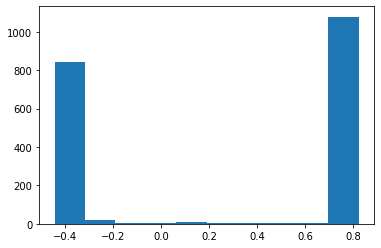

In [31]:
plt.hist(preds)

In [32]:
from utils.backtest import calc_single_asset_backtest
backtest_results = {}
for asset, sub_df in df.groupby('Asset_Col'):
    sub_df = sub_df.set_index('Date_Col', drop=False)
    sub_df = sub_df['1995-1-1':'2000-1-1']
    signal = pd.Series(model.predict(sub_df[feature_labels].values).reshape(-1), index=sub_df['Date_Col'])
    positions = signal * 0.15 / sub_df['Sigma']
    positions = positions.ewm(span=21).mean()
    positions = positions.shift(1)
    backtest_results[asset] = calc_single_asset_backtest(sub_df.Returns_Daily, sub_df.Excess_Returns_Daily, positions)
#     break

In [33]:
positions

Date_Col
1995-01-31         NaN
1995-02-28   -4.241306
1995-03-31   -4.702351
1995-05-31   -4.635872
1995-06-30   -4.488657
1995-07-31   -1.325452
1995-08-31    0.794683
1995-10-31    2.405283
1995-11-30    3.929185
1996-01-31    5.038527
1996-02-29    4.571092
1996-04-30    5.415372
1996-05-31    5.925174
1996-07-31    6.340871
1996-09-30    6.607510
1996-10-31    7.074728
1996-12-31    7.338870
1997-01-31    7.751087
1997-02-28    8.265338
1997-03-31    8.717987
1997-04-30    8.796674
1997-06-30    9.035088
1997-07-31    9.308361
1997-09-30    9.645332
1997-10-31    8.086962
1997-12-31    6.706899
1998-03-31    5.280476
1998-04-30    4.315240
1998-06-30    3.421569
1998-07-31    2.664377
1998-08-31    1.978490
1998-09-30    1.474770
1998-11-30    1.013434
1998-12-31    0.650426
1999-03-31    0.400402
1999-04-30    0.131585
1999-06-30    0.674615
1999-08-31    0.307953
1999-09-30    0.001115
1999-11-30    0.499793
dtype: float64

In [34]:
backtest_df = pd.DataFrame(backtest_results).T

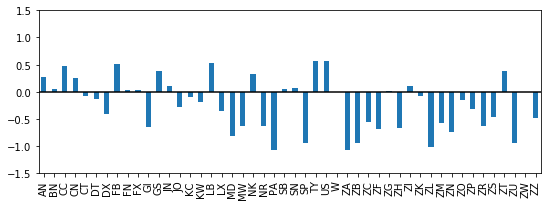

In [35]:
plt.figure(figsize=(9, 3))
backtest_df.Sharpe.plot('bar')
plt.ylim(-1.5, 1.5)
plt.hlines(0, -10, 90)

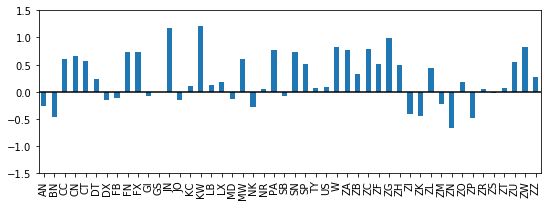

In [292]:
plt.figure(figsize=(9, 3))
backtest_df.Sharpe.plot('bar')
plt.ylim(-1.5, 1.5)
plt.hlines(0, -10, 90)